# notebooks/pulse\_score.ipynb

**Overview**
This notebook ingests Buffalo raw data from Athena, spatially joins to 2020 Census tracts, computes tract-level metrics (crime, vacancy, permits, licences, 311), derives a composite score, and stores results for visualization and LLM narration.

---
## 1. Load and clean data
### 1.1 Setup & Imports


In [1]:
import json
import os
import numpy as np
import awswrangler as wr
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.geometry as geom
from sklearn.metrics import root_mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import shap

/Users/colinspear/dev/civic-pulse-rochester/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Configure AWS:


In [2]:
os.environ['AWS_REGION'] = 'us-east-1'
wr.config.athena_workgroup = 'primary'
DATABASE = 'civic_pulse'


---

### 1.2. Load Raw Tables from Athena


In [3]:
def read_last_n_event_days(table: str, ts_col: str, n: int = 30) -> pd.DataFrame:
    """
    Pull last `n` days of events from an Athena raw_* table.
    * Adds a partition predicate on `year` to cut the scan.
    * Streams results in chunksize blocks to avoid S3 timeouts.
    """
    sql = f"""
        SELECT *
        FROM {DATABASE}.{table}
        WHERE {ts_col} >= date_add('day', -{n}, current_timestamp)
          AND year >= cast(year(date_add('day', -{n}, current_timestamp)) as varchar)
    """

    chunks = wr.athena.read_sql_query(
        sql,
        database=DATABASE,
        chunksize=200_000,
        # unload_approach=True,
        ctas_approach=False
    )
    return pd.concat(chunks, ignore_index=True)

HIST_DAYS = 365
INDEX_DAYS = 30

cut_hist   = pd.Timestamp.utcnow() - pd.Timedelta(days=HIST_DAYS)
cut_index  = pd.Timestamp.utcnow() - pd.Timedelta(days=INDEX_DAYS)

crime_df = read_last_n_event_days("raw_buf_crime",  "incident_datetime", HIST_DAYS)
viol_df  = read_last_n_event_days("raw_buf_viol",   "date",              HIST_DAYS)
perm_df  = read_last_n_event_days("raw_buf_permits","issued",            HIST_DAYS)
biz_df   = read_last_n_event_days("raw_buf_biz",    "issdttm",           HIST_DAYS)
calls_df = read_last_n_event_days("raw_buf_311",    "createddate",       HIST_DAYS)


## Temp patch to geocode permits data
`data_ingest/geocode.py` now provide `census_batch_geocode` which is incorporated in extract scripts. The below can be deleted once new extractors have been confirmed to work properly.


In [4]:
# perm_df = pd.read_csv('permits_raw.csv')
# perm_geo = pd.read_csv('buf_permits_geocoded_all.csv')
# perm_geo['latitude'] = perm_geo['longitude'].str.split(',').str[1]
# perm_geo['longitude'] = perm_geo['longitude'].str.split(',').str[0]
# perm_df.columns = ['id', 'apno', 'aptype', 'issued', 'address', 'value', 'pulled_utc', 'year', 'month', 'day']
# perm_df = perm_df.join(perm_geo, on='id', how='left', lsuffix='_orig', rsuffix='_geo')
# perm_df.drop(['id', 'id_orig', 'Unnamed: 0', 'id_geo', 'match_ok'], axis=1, inplace=True)

# print(f'{(perm_df["latitude"].isna().sum() / perm_df.shape[0]):.1%} of records did not return geographical coordinates.')
# perm_df.head()

In [5]:

crime_df["incident_datetime"] = pd.to_datetime(crime_df["incident_datetime"], utc=True).dt.tz_localize(None)
viol_df["date"] = pd.to_datetime(viol_df["date"], utc=True).dt.tz_localize(None)
perm_df["issued"] = pd.to_datetime(perm_df["issued"], utc=True).dt.tz_localize(None)
biz_df["issdttm"] = pd.to_datetime(biz_df["issdttm"], utc=True).dt.tz_localize(None)
calls_df["createddate"] = pd.to_datetime(calls_df["createddate"], utc=True).dt.tz_localize(None)


<Axes: xlabel='latitude', ylabel='longitude'>

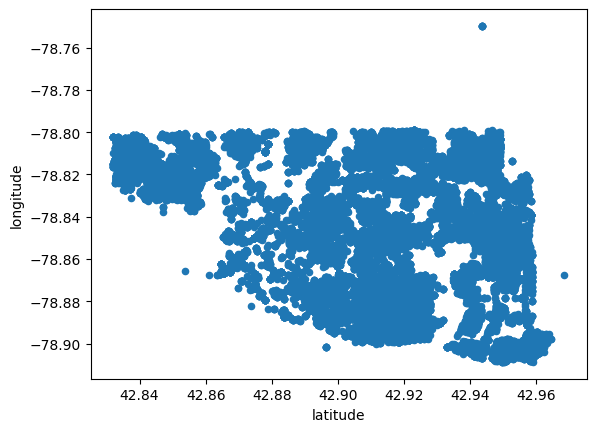

In [6]:
perm_df.plot.scatter('latitude', 'longitude')

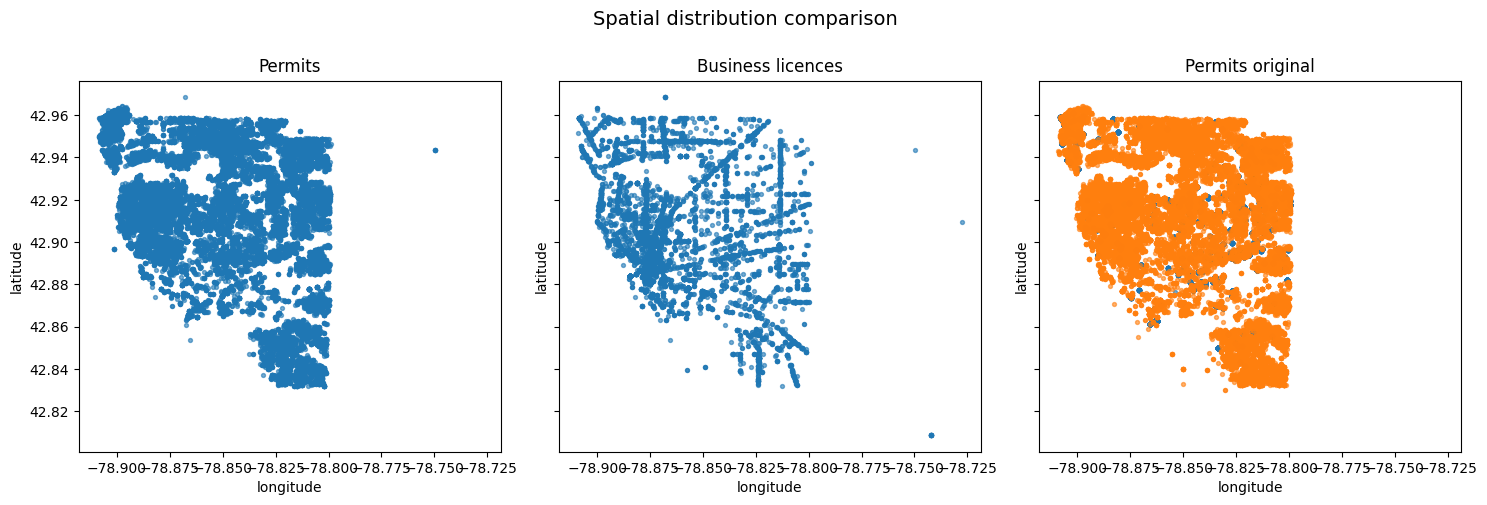

In [7]:
import matplotlib.pyplot as plt

# decide which DataFrames you want side-by-side
dfs     = [perm_df, biz_df, viol_df]          # order is the order of subplots
titles  = ['Permits', 'Business licences', 'Code violations']

n = len(dfs)
fig, axes = plt.subplots(1, n, figsize=(5 * n, 5), sharex=True, sharey=True)

# if you pass a single DataFrame, axes isn’t iterable — coerce for safety
if n == 1:
    axes = [axes]

for ax, df, title in zip(axes, dfs, titles):
    ax.scatter(df['longitude'], df['latitude'], s=8, alpha=0.6)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_aspect('equal')          # keeps map aspect correct
    
ax.scatter(perm_df['longitude_orig'], perm_df['latitude_orig'], s=8, alpha=0.6)
ax.set_title("Permits original", fontsize=12)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_aspect('equal')     

fig.suptitle('Spatial distribution comparison', fontsize=14)
fig.tight_layout()
plt.show()


In [8]:
BUFF_BOUNDS = {
    "lat_min": 42.5,   # Erie Co. southern edge ≈ 42.5 °
    "lat_max": 43.1,   # Tonawanda/Grand Island ≈ 43.1 °
    "lon_min": -79.1,  # Hamburg/Eden ≈ -79.1 °
    "lon_max": -78.4   # Clarence/Amherst ≈ -78.4 °
}

# TODO: move into extraction flow
def fix_latlon(df: pd.DataFrame,
               lat_col: str = "latitude",
               lon_col: str = "longitude",
               bounds: dict = BUFF_BOUNDS,
               label: str = "") -> pd.DataFrame:
    """
    • cast → numeric               • swap lat/lon where BOTH look swapped
    • drop rows still out-of-bounds
    """

    # numeric dtype
    df[lat_col] = pd.to_numeric(df[lat_col], errors="coerce")
    df[lon_col] = pd.to_numeric(df[lon_col], errors="coerce")

    lat_in_lat = df[lat_col].between(bounds["lat_min"], bounds["lat_max"])
    lon_in_lon = df[lon_col].between(bounds["lon_min"], bounds["lon_max"])

    # both appear swapped: lat sits in lon-range AND lon sits in lat-range
    lat_in_lon = df[lat_col].between(bounds["lon_min"], bounds["lon_max"])
    lon_in_lat = df[lon_col].between(bounds["lat_min"], bounds["lat_max"])
    to_swap    = (~lat_in_lat & ~lon_in_lon) & (lat_in_lon & lon_in_lat)
    n_swap = sum(to_swap)

    # irreparable rows = still out-of-bounds after potential swap
    df.loc[to_swap, [lat_col, lon_col]] = df.loc[to_swap, [lon_col, lat_col]].values
    lat_good = df[lat_col].between(bounds["lat_min"], bounds["lat_max"])
    lon_good = df[lon_col].between(bounds["lon_min"], bounds["lon_max"])
    to_drop  = ~(lat_good & lon_good)
    n_drop = sum(to_drop)

    before = len(df)
    df.drop(index=df.index[to_drop], inplace=True)

    pre = f"{label}: " if label else ""
    print(f"{pre}lat/lon fixed: {to_swap.sum():>6,} ({(n_swap/before):.2%} of total)")
    print(f"{pre}rows dropped:  {to_drop.sum():>6,} ({(n_drop/before):.2%} of total)")

    return df.reset_index(drop=True)


In [9]:
crime_df = fix_latlon(crime_df, label="crime_df")
viol_df = fix_latlon(viol_df, label="viol_df")
perm_df = fix_latlon(perm_df, label="perm_df")
biz_df   = fix_latlon(biz_df,   label="biz_df")
calls_df = fix_latlon(calls_df, label="calls_df")


crime_df: lat/lon fixed:      0 (0.00% of total)
crime_df: rows dropped:  12,829 (6.78% of total)
viol_df: lat/lon fixed:      0 (0.00% of total)
viol_df: rows dropped:       0 (0.00% of total)
perm_df: lat/lon fixed:      0 (0.00% of total)
perm_df: rows dropped:  259,225 (91.54% of total)
biz_df: lat/lon fixed:      0 (0.00% of total)
biz_df: rows dropped:     333 (3.83% of total)
calls_df: lat/lon fixed: 744,334 (99.60% of total)
calls_df: rows dropped:   2,998 (0.40% of total)



---

### 1.3. Load 2020 Tract Shapefile


In [10]:
# NY State tracts (state FIPS 36) from TIGER 2024
url = ("https://www2.census.gov/geo/tiger/TIGER2024/TRACT/"
       "tl_2024_36_tract.zip")

tracts = gpd.read_file(url)[["GEOID", "geometry"]].to_crs(epsg=4326)
tracts = tracts[tracts["GEOID"].str.startswith("36029")].copy()

In [11]:
path = "../data/acs2023_erie_tract_pop.json"   # adjust as needed

with open(path) as f:
    rows = json.load(f)        # rows[0] = header list, rows[1:] = data

header, data = rows[0], rows[1:]
acs = pd.DataFrame(data, columns=header)

# numeric casts
acs["population"]     = pd.to_numeric(acs["B02001_001E"], errors="coerce")
acs["housing_units"]  = pd.to_numeric(acs["B25001_001E"], errors="coerce")

# 11-digit GEOID
acs["GEOID"] = (
    acs["state"].str.zfill(2) +
    acs["county"].str.zfill(3) +
    acs["tract"].str.zfill(6)
)

acs = acs[["GEOID", "population", "housing_units"]]

tracts = tracts.merge(acs, on="GEOID", how="left")

---

### 1.4. Spatial Join Points → Tracts


In [12]:
def join_points(df, lon='longitude', lat='latitude'):
    """
    If lon/lat columns are present, spatially join to tracts.
    Otherwise just add a null 'tract' column and return the original df.
    """
    if lon in df.columns and lat in df.columns:
        gdf = gpd.GeoDataFrame(
            df,
            geometry=gpd.points_from_xy(df[lon], df[lat]),
            crs='EPSG:4326'
        )
        out = gpd.sjoin(gdf, tracts[['GEOID', 'geometry']],
                        how='left', predicate='within')
        return out.drop(columns='geometry').rename(columns={'GEOID': 'tract'})
    else:
        df = df.copy()
        df['tract'] = pd.NA
        return df

crime_gdf = join_points(crime_df)
viol_gdf  = join_points(viol_df)
perm_gdf  = join_points(perm_df)
biz_gdf   = join_points(biz_df)
calls_gdf = join_points(calls_df)


---
## 2. Pulse index
### 2.1. Compute Tract-Level Metrics


In [13]:
crime_recent = crime_gdf[crime_gdf["incident_datetime"] >= cut_index.tz_localize(None)]
viol_recent  = viol_gdf [viol_gdf ["date"]              >= cut_index.tz_localize(None)]
perm_recent  = perm_gdf [perm_gdf ["issued"]            >= cut_index.tz_localize(None)]
biz_recent   = biz_gdf  [biz_gdf  ["issdttm"]           >= cut_index.tz_localize(None)]
calls_recent = calls_gdf[calls_gdf["createddate"]       >= cut_index.tz_localize(None)]

# initialise metrics with all tracts
metrics = pd.DataFrame({
    "tract": tracts["GEOID"],
    "population": tracts["population"],
    "housing_units": tracts["housing_units"]
})


In [14]:
# --------------------------------------------------
# build raw counts  (already in `metrics`)
# --------------------------------------------------
crime_tract = crime_recent.groupby('tract', as_index=False).size()
crime_tract.columns = ["tract", "crime_cnt"]
metrics = pd.merge(metrics, crime_tract, on="tract", how='left')

viol_tract = viol_recent.groupby('tract', as_index=False).size()
viol_tract.columns = ["tract", "vacant_code_cnt"]
metrics = pd.merge(metrics, viol_tract, on="tract", how='left')

perm_tract = perm_recent.groupby('tract', as_index=False).size()
perm_tract.columns = ["tract", "permit_cnt"]
metrics = pd.merge(metrics, perm_tract, on="tract", how='left')

biz_tract = biz_recent.groupby('tract', as_index=False).size()
biz_tract.columns = ["tract", "licence_cnt"]
metrics = pd.merge(metrics, biz_tract, on="tract", how='left')

calls_tract = calls_recent.groupby('tract', as_index=False).size()
calls_tract.columns = ["tract", "calls_cnt"]
metrics = pd.merge(metrics, calls_tract, on="tract", how='left')

metrics = metrics.fillna(0).astype({"crime_cnt":   "Int64",
                                     "vacant_code_cnt": "Int64",
                                     "permit_cnt":      "Int64",
                                     "licence_cnt":     "Int64",
                                     "calls_cnt":       "Int64"})


In [15]:

# --------------------------------------------------
# per-capita rates  (crime per-1 k pop, etc.)
# --------------------------------------------------
metrics["crime_rate"]   = metrics["crime_cnt"]   / (metrics["population"]/1_000)
metrics["vacant_rate"]  = metrics["vacant_code_cnt"] / (metrics["housing_units"]/1_000)
metrics["permit_rate"]  = metrics["permit_cnt"]  / (metrics["housing_units"]/1_000)
metrics["licence_rate"] = metrics["licence_cnt"] / (metrics["population"]/1_000)
metrics["calls_rate"]   = metrics["calls_cnt"]   / (metrics["population"]/1_000)

# --------------------------------------------------
# z-scores (feature list = *_rate columns)
# --------------------------------------------------
features = [c for c in metrics.columns if c.endswith("_rate")]
scaler   = StandardScaler()
metrics[[f.replace("_rate", "_z") for f in features]] = scaler.fit_transform(metrics[features])

# composite pulse score
metrics["score"] = metrics[[f.replace("_rate","_z") for f in features]].sum(axis=1)

---
## 3. Boosted tree model and SHAP scores
### 3.1 Build weekly dataset

In [84]:
# ──────────────────────────────────────────────────────────────────────
# XGBoost / SHAP TRAINING PIPELINE  ── rate + count features, log/ raw target toggle
# ──────────────────────────────────────────────────────────────────────

# ------------------------------------------------------------------ #
# 0. PARAMS
# ------------------------------------------------------------------ #
TARGET_MODE   = "log"          # "raw" OR "log"
TEST_WEEKS    = 4              # hold-out horizon
CUT_NOW       = pd.Timestamp.utcnow().to_period("W-SUN").start_time

# ------------------------------------------------------------------ #
# 1. Clean datetimes + remove future rows
# ------------------------------------------------------------------ #
for gdf, col in [
    (crime_gdf, "incident_datetime"),
    (viol_gdf,  "date"),
    (perm_gdf,  "issued"),
    (biz_gdf,   "issdttm"),
    (calls_gdf, "createddate"),
]:
    gdf[col] = pd.to_datetime(gdf[col],  utc=True,
                              errors="coerce").dt.tz_localize(None)
    gdf["week"] = gdf[col].dt.to_period("W-SUN").dt.start_time
    gdf.drop(index=gdf.loc[gdf["week"] > CUT_NOW].index, inplace=True)

# ------------------------------------------------------------------ #
# 2. Target table  calls_next_week  >>> weekly_y
# ------------------------------------------------------------------ #
weekly_y = (
    calls_gdf.groupby(["tract","week"]).size()
             .rename("calls_next_week").reset_index()
)
weekly_y["week"] = weekly_y["week"] - pd.Timedelta(weeks=1)   # week t predicts t+1

# ------------------------------------------------------------------ #
# 3. Predictor weekly counts        >>> weekly_pred
# ------------------------------------------------------------------ #
def weekly_size(df, name):
    return df.groupby(["tract","week"]).size().rename(name).reset_index()

weekly_pred = (
    weekly_size(crime_gdf, "crime_count")
      .merge(weekly_size(viol_gdf, "vacant_code_count"), on=["tract","week"], how="outer")
      .merge(weekly_size(perm_gdf, "permit_count"),      on=["tract","week"], how="outer")
      .merge(weekly_size(biz_gdf,  "licence_count"),     on=["tract","week"], how="outer")
      .fillna(0)
)

# ------------------------------------------------------------------ #
# 4. Per-capita / per-unit rates
# ------------------------------------------------------------------ #
pop_hu = tracts[["GEOID","population","housing_units"]].rename(columns={"GEOID":"tract"})
weekly_pred = weekly_pred.merge(pop_hu, on="tract", how="left")
weekly_pred["population"].replace(0, np.nan, inplace=True)
weekly_pred["housing_units"].replace(0, np.nan, inplace=True)

weekly_pred["crime_per_1k"]   = weekly_pred["crime_count"]           / (weekly_pred["population"]      / 1_000)
weekly_pred["vacant_per_1khu"] = weekly_pred["vacant_code_count"]     / (weekly_pred["housing_units"]   / 1_000)
weekly_pred["permit_per_1khu"] = weekly_pred["permit_count"]          / (weekly_pred["housing_units"]   / 1_000)
weekly_pred["lic_per_1khu"]    = weekly_pred["licence_count"]         / (weekly_pred["housing_units"]   / 1_000)
weekly_pred["log_licence"] = np.log1p(weekly_pred["licence_count"])
weekly_pred["log_permits"] = np.log1p(weekly_pred["permit_count"])

# raw + rate feature list
feature_cols = [
    # "crime_per_1k", 
    "crime_count",
    # "vacant_per_1khu", 
    "vacant_code_count",
    # "permit_per_1khu", 
    # "permit_count",
    "log_permits",
    # "lic_per_1khu",    
    # "licence_count",
    "log_licence"
]

# ------------------------------------------------------------------ #
# 5. Join predictors ↔ target       >>> weekly_full
# ------------------------------------------------------------------ #
weekly_full = weekly_pred.merge(
    weekly_y, on=["tract","week"], how="inner"
).fillna(0)

# ------------------------------------------------------------------ #
# 6. Train / Test split
# ------------------------------------------------------------------ #
cutoff = weekly_full["week"].max() - pd.Timedelta(weeks=TEST_WEEKS)
train  = weekly_full[weekly_full.week <  cutoff].set_index(["tract","week"])
test   = weekly_full[weekly_full.week >= cutoff].set_index(["tract","week"])

X_train = train[feature_cols]
X_test  = test[feature_cols]

# ---------- target (raw or log) ----------
if TARGET_MODE == "log":
    y_train = np.log1p(train["calls_next_week"])
    y_test  = np.log1p(test["calls_next_week"])
else:
    y_train = train["calls_next_week"]
    y_test  = test["calls_next_week"]

# ------------------------------------------------------------------ #
# 7. Fit model
# ------------------------------------------------------------------ #
model = xgb.XGBRegressor(
    n_estimators=300, max_depth=4, learning_rate=0.05,
    objective="reg:squarederror", subsample=0.8, colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train.values, y_train.values)

# ------------------------------------------------------------------ #
# 8. SHAP values
# ------------------------------------------------------------------ #
explainer   = shap.Explainer(model, X_train.values, feature_names=feature_cols)
shap_values = explainer(X_test.values)   # passes additivity by default

print(f"✅ XGB done – feature matrix {X_train.shape},  SHAP {shap_values.shape}")


/var/folders/tj/2zm1pzk90t177_g7ndj99_y00000gn/T/ipykernel_45943/1588303816.py:10: UserWarning: Converting to Period representation will drop timezone information.
  CUT_NOW       = pd.Timestamp.utcnow().to_period("W-SUN").start_time
/var/folders/tj/2zm1pzk90t177_g7ndj99_y00000gn/T/ipykernel_45943/1588303816.py:55: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weekly_pred["population"].replace(0, np.nan, inplace=True)
/var/folders/tj/2zm1pzk90t177_g7ndj99_y00000gn/T/ipykernel_45943/1588303816.py:56: FutureWarning: A value is t

✅ XGB done – feature matrix (4076, 4),  SHAP (377, 4)


In [85]:
from sklearn.metrics import r2_score, mean_absolute_error
pred = model.predict(X_test.values)
if TARGET_MODE == "log":
    pred = np.expm1(pred)       # back-transform
    y_true = np.expm1(y_test)
else:
    y_true = y_test
print("R² =", r2_score(y_true, pred))
print("MAE=", mean_absolute_error(y_true, pred))


R² = -19.591050591153245
MAE= 30.00199165015385


---

## 4. Sanity-check suite for Civic-Pulse GBM + SHAP


In [86]:
results = {}

# 2. Target variance -----------------------------------------------
results["var_train"] = y_train.var()
results["var_test"]  = y_test.var()
print("Target variance – train:", results["var_train"], "test:", results["var_test"])


Target variance – train: 1.6171143551937806 test: 0.5840049778588766


In [87]:
# 3. Baseline vs. model RMSE ---------------------------------------
dummy = DummyRegressor(strategy="mean").fit(X_train, y_train)
rmse_dummy = root_mean_squared_error(y_test, dummy.predict(X_test))
rmse_xgb   = root_mean_squared_error(y_test,  model.predict(X_test))
results["rmse_baseline"] = rmse_dummy
results["rmse_xgb"]      = rmse_xgb
print("RMSE  baseline:", rmse_dummy, "  XGB:", rmse_xgb,
      f"\nXGB {(rmse_dummy - rmse_xgb)/rmse_dummy:.02%} lower than baseline."
      "\n(Expect XGB at least ~10 % lower)")


RMSE  baseline: 2.008872907661601   XGB: 1.3016764338904931 
XGB 35.20% lower than baseline.
(Expect XGB at least ~10 % lower)


([<matplotlib.axis.YTick at 0x14a3fafa0>,
 [Text(0, 0, 'crime_count'),
  Text(0, 1, 'vacant_code_count'),
  Text(0, 2, 'log_permits'),
  Text(0, 3, 'log_licence')])

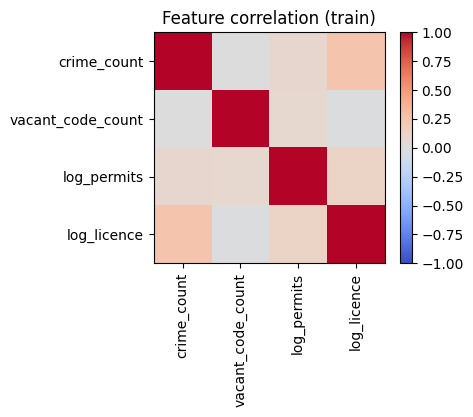

In [88]:

# 4. Feature correlation heat-map ----------------------------------
corr = pd.DataFrame(X_train, columns=feature_cols).corr()
plt.figure(figsize=(4,3)); plt.title("Feature correlation (train)")
plt.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm"); plt.colorbar()
plt.xticks(range(len(feature_cols)),feature_cols,rotation=90); plt.yticks(range(len(feature_cols)),feature_cols)
# Eyeball: any cell >|0.95| → drop one of the twins.


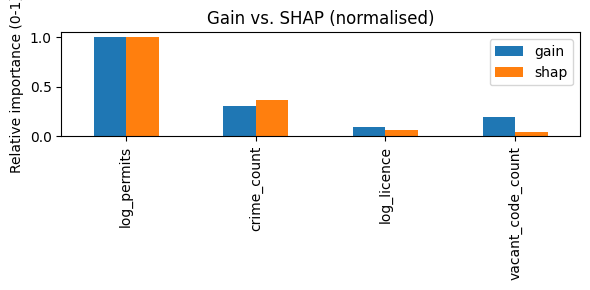

In [89]:
# 5. Gain vs. SHAP ranking -----------------------------------------
booster   = model.get_booster()
gain_dict = booster.get_score(importance_type='gain')

# map f0, f1, … to column names in feature_cols
gain_vec  = np.array([gain_dict.get(f"f{i}", 0) for i in range(len(feature_cols))])
shap_mean = np.abs(shap_values.values).mean(axis=0)

norm = lambda x: x / x.max() if x.max() else x
df_norm = pd.DataFrame({"gain": norm(gain_vec), "shap": norm(shap_mean)},
                       index=feature_cols).sort_values("shap", ascending=False)
df_norm.plot.bar(figsize=(6,3))
plt.ylabel("Relative importance (0-1)")
plt.title("Gain vs. SHAP (normalised)")
plt.tight_layout()


In [90]:

# 6. Additivity already checked by SHAP call -----------------------
print("SHAP additivity check passed earlier ✔")


SHAP additivity check passed earlier ✔


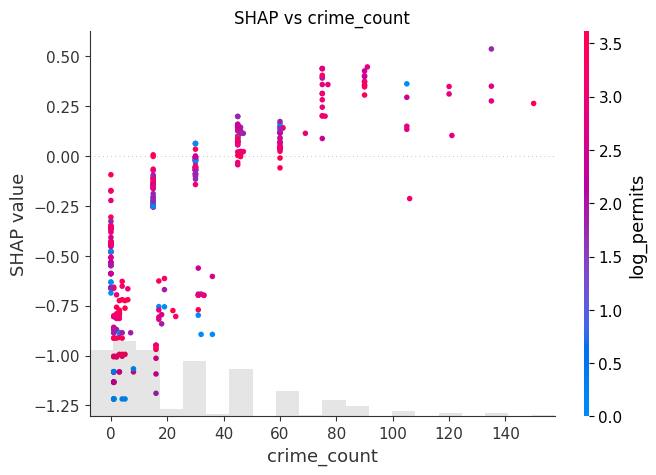

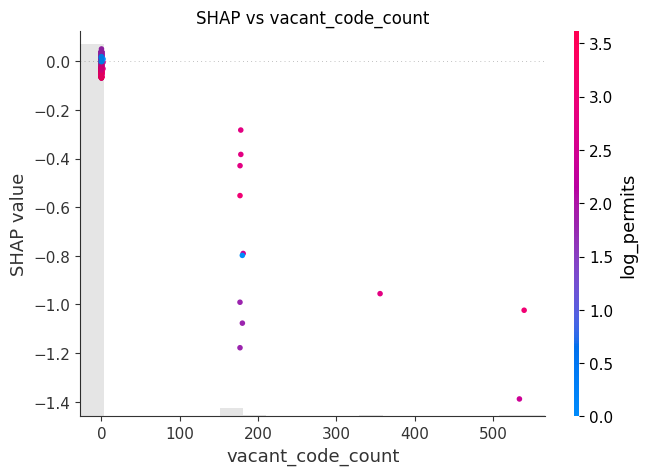

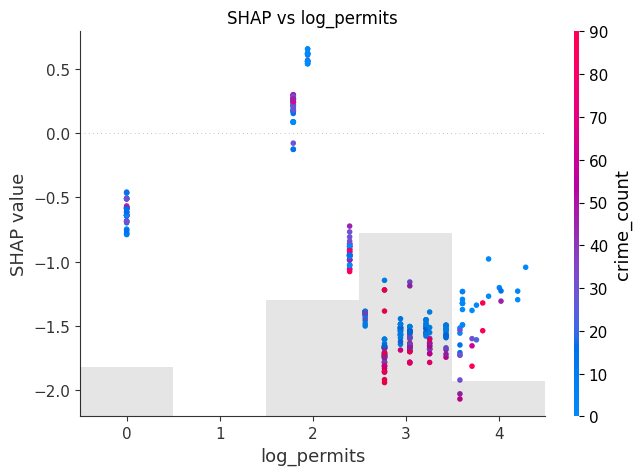

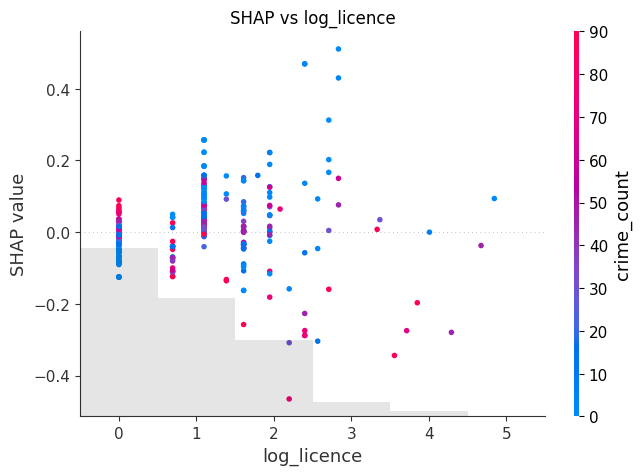

In [91]:

# 7. Direction sanity (scatter) ------------------------------------
for feat in feature_cols:
    disp = shap.plots.scatter(
        shap_values[:, feature_cols.index(feat)],
        color=shap_values,
        show=False
    )
    plt.title(f"SHAP vs {feat}")
    plt.xlabel(feat); plt.ylabel("SHAP value")
    plt.show()
    # Eyeball: monotone trend (upwards for risk-raising features).
    # U-shapes or clouds → clipping / transformation needed.


In [92]:

# 8. Stability across cut-offs ------------------------------------
from scipy.stats import spearmanr

# baseline ranking: mean(|SHAP|) on the main test set
rank0 = pd.Series(np.abs(shap_values.values).mean(0),
                  index=feature_cols).rank()

cutoff_max = weekly_full["week"].max()

for w in range(2, 6):      # 2- to 5-week hold-out slices
    cut = cutoff_max - pd.Timedelta(weeks=w)
    subset = weekly_full[weekly_full.week >= cut][feature_cols]

    if subset.empty:
        continue           # nothing to compare

    shap_subset = explainer(subset.values, check_additivity=False)
    rank_w = pd.Series(np.abs(shap_subset.values).mean(0),
                       index=feature_cols).rank()

    rho = spearmanr(rank0, rank_w).correlation
    print(f"Rank corr vs. {w:>2}-week window: {rho:.2f}  (expect ≥ 0.70)")


Rank corr vs.  2-week window: 1.00  (expect ≥ 0.70)
Rank corr vs.  3-week window: 1.00  (expect ≥ 0.70)
Rank corr vs.  4-week window: 1.00  (expect ≥ 0.70)
Rank corr vs.  5-week window: 1.00  (expect ≥ 0.70)


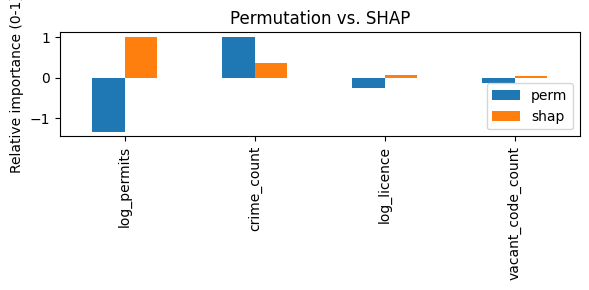

In [93]:

# 9. Permutation importance ----------------------------------------
perm = permutation_importance(model, X_test, y_test, n_repeats=30,
                              random_state=0)
perm_imp = pd.Series(perm.importances_mean, index=feature_cols)

norm = lambda x: x / x.max() if x.max() else x

df_norm = pd.DataFrame({"perm": norm(perm_imp), "shap": norm(shap_mean)},
                       index=feature_cols).sort_values("shap", ascending=False)

df_norm.plot.bar(figsize=(6,3))
plt.ylabel("Relative importance (0-1)")
plt.title("Permutation vs. SHAP"); plt.tight_layout()
plt.tight_layout()
# Eyeball: top few features align ≈; divergence → investigate.



Finished sanity checks – see plots & prints above.


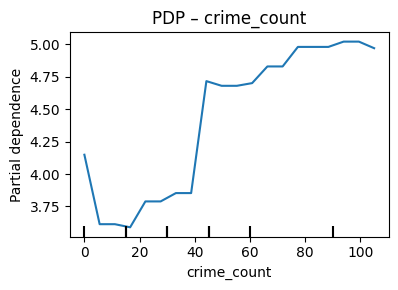

In [94]:

# 10. Partial-dependence sanity ------------------------------------
fig, ax = plt.subplots(figsize=(4,3))
PartialDependenceDisplay.from_estimator(model, X_train, [feature_cols[0]],
                                        grid_resolution=20, ax=ax)
plt.title(f"PDP – {feature_cols[0]}"); plt.tight_layout()
# Eyeball: curve should rise logically (e.g., more crime → more 311).

print("\nFinished sanity checks – see plots & prints above.")


---

## 5. Save Results to S3

In [95]:
# build pulse_metrics_df  (already in RAM right after compute_score)
metrics["30_day_start"] = cut_index.strftime("%Y-%m-%d")
metrics = metrics.drop(['population', 'housing_units'], axis=1)


KeyError: "['population', 'housing_units'] not found in axis"

In [96]:
metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tract            261 non-null    object 
 1   crime_cnt        261 non-null    Int64  
 2   vacant_code_cnt  261 non-null    Int64  
 3   permit_cnt       261 non-null    Int64  
 4   licence_cnt      261 non-null    Int64  
 5   calls_cnt        261 non-null    Int64  
 6   crime_rate       261 non-null    Float64
 7   vacant_rate      261 non-null    Float64
 8   permit_rate      261 non-null    Float64
 9   licence_rate     261 non-null    Float64
 10  calls_rate       261 non-null    Float64
 11  crime_z          260 non-null    float64
 12  vacant_z         257 non-null    float64
 13  permit_z         257 non-null    float64
 14  licence_z        260 non-null    float64
 15  calls_z          260 non-null    float64
 16  score            261 non-null    float64
 17  30_day_start    

In [97]:
wr.s3.to_parquet(
    metrics,
    path=f"s3://civic-pulse-rochester/pulse/metrics/",
    dataset=True,
    partition_cols=["30_day_start"],
    mode="overwrite_partitions",
    compression="zstd"
)

{'paths': ['s3://civic-pulse-rochester/pulse/metrics/30_day_start=2025-04-28/9f14efdbf6924c8cb9801386840e9cb8.zstd.parquet'],
 'partitions_values': {'s3://civic-pulse-rochester/pulse/metrics/30_day_start=2025-04-28/': ['2025-04-28']}}

In [98]:
# build pulse_shap_df  (explode SHAP → long format)
shap_df = pd.DataFrame(
    shap_values.values,          # rows align with X_test
    columns = feature_cols,
    index   = test.index         # keeps the original MultiIndex
).reset_index()[["tract", "week", *feature_cols]]

shap_long = (
    shap_df
    .melt(id_vars=["tract", "week"], var_name="feature", value_name="shap")
)
shap_long['week'] = shap_long["week"].dt.strftime("%Y-%m-%d")

In [99]:
shap_long.head()

,tract,week,feature,shap
0,36029000110,2025-04-21,crime_count,0.115356
1,36029000110,2025-04-28,crime_count,0.244473
2,36029000110,2025-05-05,crime_count,-0.057691
3,36029000110,2025-05-12,crime_count,-0.948879
4,36029000200,2025-04-21,crime_count,0.006737


In [100]:

wr.s3.to_parquet(
    shap_long,
    path=f"s3://civic-pulse-rochester/pulse/shap/",
    dataset=True,
    partition_cols=["week"],
    mode="overwrite_partitions",
    compression="zstd"
)

{'paths': ['s3://civic-pulse-rochester/pulse/shap/week=2025-04-21/c922ae2eb38b4a6982738362386fddaf.zstd.parquet',
  's3://civic-pulse-rochester/pulse/shap/week=2025-04-28/c922ae2eb38b4a6982738362386fddaf.zstd.parquet',
  's3://civic-pulse-rochester/pulse/shap/week=2025-05-05/c922ae2eb38b4a6982738362386fddaf.zstd.parquet',
  's3://civic-pulse-rochester/pulse/shap/week=2025-05-12/c922ae2eb38b4a6982738362386fddaf.zstd.parquet',
  's3://civic-pulse-rochester/pulse/shap/week=2025-05-19/c922ae2eb38b4a6982738362386fddaf.zstd.parquet'],
 'partitions_values': {'s3://civic-pulse-rochester/pulse/shap/week=2025-04-21/': ['2025-04-21'],
  's3://civic-pulse-rochester/pulse/shap/week=2025-04-28/': ['2025-04-28'],
  's3://civic-pulse-rochester/pulse/shap/week=2025-05-05/': ['2025-05-05'],
  's3://civic-pulse-rochester/pulse/shap/week=2025-05-12/': ['2025-05-12'],
  's3://civic-pulse-rochester/pulse/shap/week=2025-05-19/': ['2025-05-19']}}


---

*Next:* Fill in ACS population load, training data for SHAP, and refine model fitting.
